In [1]:
# Импорт библиотек
import numpy as np
import pandas as pd
import lightgbm as lgb
import hyperopt
import random
import time
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hyperopt.pyll import scope
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
import matplotlib.pyplot as plt

In [3]:
del X_train['Id']

In [4]:
X_train.columns

Index(['sex', 'НЕВЕРОТН 1  Невероятные приключения итальянцев в России',
       'ТЕЛОХРАН 2  Телохранитель',
       'КАВКАЗСК 3  Кавказская пленница или Новые приключения Шурика',
       'ПТЫЙ_ЭЛЕ 4  Пятый элемент', 'ТЕРМИНАТ 5  Терминатор',
       'КРЕПКИЙ 6  Крепкий орешек', 'ПОЛИЦ_АК 7  Полицейская академия',
       'ЧУЖИЕ 8  Чужие', 'КРОКОДИЛ 9  Крокодил Данди',
       ...
       'РУКА_ПЕР 191 Рука-переплетение пальцев рук - ведущая',
       'РУКА_ИМИ 192 Рука-имитация аплодисментов - ведущая',
       'РУКА_СКР 193 Рука-скрещивание рук на груди - ведущая',
       'HОГА 194 Hога - ведущая', 'ГЛАЗ 195 Глаз - ведущая',
       'РУКОЙ_ПИ 196 Рука  которой пишут',
       'ПЕРЕУЧИВ 197 Переучивали ли писать  если левша',
       'САМООПPЕ 198 Самоопpеделение пpавша-левша',
       'БОК_ПРЕД 199 Бок  на котором предпочитают спать',
       'ГЛАЗ_У_В 200 Глаз  который обычно шире открыт'],
      dtype='object', length=162)

Убираем где непонятно какой пол 

In [6]:
X_train=X_train[X_train.sex>0]

In [7]:
#cols = X_train.columns

In [8]:
#cols_del = list(X_train.isna().sum()>300)

In [9]:
 #не нужные стоблцы
#X_train=X_train.drop(cols[list(X_train.isna().sum()>300)], axis = 1)


In [5]:
X_train

,sex,НЕВЕРОТН 1 Невероятные приключения итальянцев в России,ТЕЛОХРАН 2 Телохранитель,КАВКАЗСК 3 Кавказская пленница или Новые приключения Шурика,ПТЫЙ_ЭЛЕ 4 Пятый элемент,ТЕРМИНАТ 5 Терминатор,КРЕПКИЙ 6 Крепкий орешек,ПОЛИЦ_АК 7 Полицейская академия,ЧУЖИЕ 8 Чужие,КРОКОДИЛ 9 Крокодил Данди,...,РУКА_ПЕР 191 Рука-переплетение пальцев рук - ведущая,РУКА_ИМИ 192 Рука-имитация аплодисментов - ведущая,РУКА_СКР 193 Рука-скрещивание рук на груди - ведущая,HОГА 194 Hога - ведущая,ГЛАЗ 195 Глаз - ведущая,РУКОЙ_ПИ 196 Рука которой пишут,ПЕРЕУЧИВ 197 Переучивали ли писать если левша,САМООПPЕ 198 Самоопpеделение пpавша-левша,БОК_ПРЕД 199 Бок на котором предпочитают спать,ГЛАЗ_У_В 200 Глаз который обычно шире открыт
0,2.0,5.0,6.0,8.0,11.7,8.7,8.0,8.0,5.0,3.0,...,1.0,2.0,2.0,2.0,2.0,1.0,4.0,1.0,2.0,2.0
1,1.0,7.0,7.0,7.0,10.0,3.0,9.0,6.2,12.0,2.0,...,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,3.0
2,1.0,12.0,7.0,6.0,10.0,7.0,8.0,7.0,6.0,7.0,...,2.0,1.0,2.0,1.0,2.0,1.0,4.0,2.0,3.0,2.0
3,1.0,7.0,8.0,12.0,7.0,12.0,11.0,9.0,12.0,10.0,...,2.0,2.0,1.0,2.0,2.0,1.0,NaN,1.0,3.0,1.0
4,1.0,5.0,9.0,2.0,11.0,8.0,6.0,2.0,3.0,4.0,...,1.0,2.0,2.0,2.0,2.0,1.0,4.0,1.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2.0,7.0,5.0,3.0,6.0,1.0,4.0,4.0,3.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,NaN,7.0,7.5,8.0,6.0,3.0,5.0,3.0,4.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,1.0,7.0,7.0,7.5,10.0,11.0,9.0,9.0,6.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
998,1.0,7.0,10.0,7.0,10.0,7.0,8.0,7.0,7.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


И давайте сразу же запустим тестовые 

In [6]:
X_test= pd.read_csv('predict_sex_test_no_answers_no_mv.csv', sep = ',', encoding = 'utf-8')

In [7]:
y=X_train.sex
X_train=X_train.drop(['sex'], axis = 1)

In [13]:
del X_test['Id']

In [14]:
smp = SimpleImputer(strategy='constant',fill_value= -1) # задаем параметры замены пропущенных значений
X_train = smp.fit_transform(X_train) # метод fit_transform подгоняется под тренировочный набор и на месте его преобразовывает
X_test = smp.transform(X_test)

In [15]:
# Пространство перебора гиперпараметров для hyperopt

space ={
        'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart']), # тип бустинга
        'max_depth': scope.int(hp.quniform("max_depth", 4, 10, 1)), # максимальная глубина одного дерева ансамбля
        'n_estimators': scope.int(hp.quniform('n_estimators', 100, 1000, 10)), # кол-во деревьев
        'num_leaves': scope.int(hp.quniform ('num_leaves', 20, 100, 1)), # максимальное кол-во листьев в дереве
        'min_data_in_leaf':  scope.int(hp.quniform ('min_data_in_leaf', 10, 100, 1)), # мин. кол-во наблюдений в листе
        'feature_fraction': hp.uniform('feature_fraction', 0.6, 1.0), # процент фич, используемых на одной итерации 
        'bagging_fraction': hp.uniform('bagging_fraction', 0.6, 1.0), # процент наблюдений, используемых на одной итерации
        'learning_rate': hp.uniform('learning_rate', 0.001, 0.4), # скорость обучения
        'lambda_l1': hp.uniform('lambda_l1', 1e-6, 5 ), # регуляризатор l1
        'lambda_l2': hp.uniform('lambda_l2', 1e-6, 5 ), # регулязиатор l2
        'seed': hp.randint('seed',2000000)
       }

In [16]:
# Целевая функция для hyperopt (по ней оптимизируемся)

def objective(space):
    clf = lgb.LGBMClassifier(**space)
    current_score = cross_val_score(clf, X_train, y, cv = 5, scoring = make_scorer(roc_auc_score, needs_proba = True)).mean()
    return -current_score

In [17]:
# Оптимизация hyperopt
# ДОЛГО!!! max_evals влияет на время выполнения (1 итерация приблизительно 30 минут)
best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 200)

100%|█████████████████████████████████████████████| 200/200 [22:25<00:00,  6.73s/trial, best loss: -0.8906619566451026]


In [18]:
# определеяем модель с подобранными гиперпараметрами
lgb_model = lgb.LGBMClassifier(**best)

In [19]:
best

{'bagging_fraction': 0.7952194298134458,
 'boosting_type': 1,
 'feature_fraction': 0.9364242966317508,
 'lambda_l1': 4.279665235179919,
 'lambda_l2': 3.5352970216793413,
 'learning_rate': 0.30723597084186854,
 'max_depth': 6.0,
 'min_data_in_leaf': 16.0,
 'n_estimators': 660.0,
 'num_leaves': 100.0,
 'seed': 1008949}

In [20]:
best['boosting_type'] ='dart'

In [17]:
best['num_leaves'] =75
best['max_depth'] =7
best['min_data_in_leaf'] =13
best['n_estimators'] =600

In [21]:
# минут 10, обучение неоткалиброванной модели с наилучшими гиперпараметрами
lgb_model.fit(X_train, y)

LGBMClassifier(bagging_fraction=0.9413852420846343, boosting_type='dart',
               class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.6849614453531285, importance_type='split',
               lambda_l1=0.41708052179794475, lambda_l2=0.21867400489724648,
               learning_rate=0.34098579465607776, max_depth=7,
               min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=13, min_split_gain=0.0, n_estimators=600,
               n_jobs=-1, num_leaves=75, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, seed=340621, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [22]:
lgb_predict_test = lgb_model.predict_proba(X_test)[:,1]

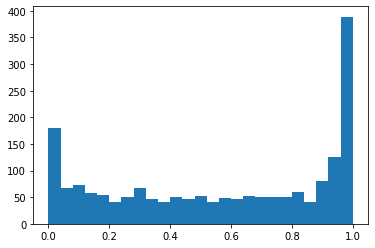

In [23]:
import matplotlib.pyplot as plt
plt.hist(lgb_predict_test, bins = 25)
plt.show()

In [24]:
lgb_predict_test.mean()

0.5689276848896325

In [25]:
import statistics
statistics.median(lgb_predict_test)

0.6122344200376918

In [26]:
lgb_pred = pd.Series(lgb_predict_test)
lgb_pred = lgb_pred.apply(lambda x: 2 if x >= 0.61 else 1)

In [35]:
lgb_pred.to_csv('result.csv')

In [27]:
lgb_pred=pd.DataFrame(lgb_pred)

In [33]:
lgb_pred.columns=['Sex']
lgb_pred

,Sex
Id,
1002,2
1003,2
1004,2
1005,2
1006,2
...,...
3493,1
3494,2
3497,1


In [32]:
lgb_pred.index=X_testt.Id

In [30]:
X_testt= pd.read_csv('predict_sex_test_no_answers_no_mv.csv', sep = ',', encoding = 'utf-8')

In [31]:
X_testt.Id

0       1002
1       1003
2       1004
3       1005
4       1006
        ... 
1854    3493
1855    3494
1856    3497
1857    3498
1858    3499
Name: Id, Length: 1859, dtype: int64

In [36]:
lgb_pred.to_csv('result_med.csv')